# NYC MTA Turnstile Usage Dataset

Have a look at / download the following dataset :

- Go to http://web.mta.info/developers/turnstile.html
- This dataset shows entry & exit counter values for each turnstile-device in each station in the NYC Subway System.
- Note these aren’t counts per interval, but equivalent to an “odometer” reading for each device.
 

# Step 0 - data download

Since the analytics and visulization tasks are based on 2013 data stats. I only downloaded the last day of 2011, all 2012 data, all 2013 data, and the first day of 2014.

Tool used: Firefox plugin --- DownThemAll!!!

In [1]:
# files were downloaded to 
work_path = "/Users/Wenjie/Projects/GitHub/Tinny/TS/MTA"

# Step 1 - raw data load

In [2]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import os, sys
import csv
import glob
import math

from datetime import datetime
from glob     import glob

In [204]:
#file_list = glob( work_path + "/*.txt" )
file_list = ["turnstile_130810.txt", "turnstile_130817.txt", "turnstile_130824.txt",
             "turnstile_121208.txt", "turnstile_121215.txt", "turnstile_121222.txt"]

# header used
header = ("C/A,UNIT,SCP," + \
          "DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2," + \
          "DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4," + \
          "DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6," + \
          "DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8").split(",")

df_raw_list = []
for filename in file_list:
    try:
        df_raw = pd.read_csv(work_path + "/" + filename, sep = ',', header = None)
        #df_raw = pd.read_csv(filename, sep = ',', header = None)
        df_raw.columns = header
        df_raw_list.append( df_raw )
    except:
        pass

len(df_raw_list)

6

In [205]:
# convert format from

# ca,unit,scp,rec1 ... rec8
# .
# .
# to
# ca,unit,scp,rec1
# ca,unit,scp,rec2
# .
# .

def mta_df_normalization( df ):
    """ normalize the data frame. claps datetime, desc, entries, and exists """
    
    columns_name = ["C/A","UNIT","SCP","Date","Time","Desc","Entries","Exits"]    
    df_out       = pd.DataFrame(columns = columns_name)
    
    rec_1 = df[ ["C/A","UNIT","SCP","DATE1","TIME1","DESC1","ENTRIES1","EXITS1"] ]; rec_1.columns = columns_name
    rec_2 = df[ ["C/A","UNIT","SCP","DATE2","TIME2","DESC2","ENTRIES2","EXITS2"] ]; rec_2.columns = columns_name 
    rec_3 = df[ ["C/A","UNIT","SCP","DATE3","TIME3","DESC3","ENTRIES3","EXITS3"] ]; rec_3.columns = columns_name
    rec_4 = df[ ["C/A","UNIT","SCP","DATE4","TIME4","DESC4","ENTRIES4","EXITS4"] ]; rec_4.columns = columns_name
    rec_5 = df[ ["C/A","UNIT","SCP","DATE5","TIME5","DESC5","ENTRIES5","EXITS5"] ]; rec_5.columns = columns_name
    rec_6 = df[ ["C/A","UNIT","SCP","DATE6","TIME6","DESC6","ENTRIES6","EXITS6"] ]; rec_6.columns = columns_name
    rec_7 = df[ ["C/A","UNIT","SCP","DATE7","TIME7","DESC7","ENTRIES7","EXITS7"] ]; rec_7.columns = columns_name
    rec_8 = df[ ["C/A","UNIT","SCP","DATE8","TIME8","DESC8","ENTRIES8","EXITS8"] ]; rec_8.columns = columns_name
    
    df_out = pd.concat( [rec_1, rec_2, rec_3, rec_4, rec_5, rec_6, rec_7, rec_8] )
    
    return df_out

norm_list = [ mta_df_normalization( df ) for df in df_raw_list]
df_norm   = pd.concat( norm_list )
df_norm.shape

(1379000, 8)

In [234]:
df_norm.dtypes

C/A                 object
UNIT                object
SCP                 object
Date                object
Time                object
Desc                object
Entries            float64
Exits              float64
Station             object
DateTime    datetime64[ns]
Year                object
Quarter             object
dtype: object

# Step 2 - data pre-processing / cleaning

- definiton of "station"
- datetime convertion
- hourly / daily traffic calculation
- anormilies and outliers cleaning

In [206]:
del norm_list

In [207]:
# definition of "station"

# data source: Remote-Booth-Station.xls
remote_station_xls = pd.ExcelFile(work_path + "/" + "Remote-Booth-Station.xls")
df_remote_station  = remote_station_xls.parse( "Remote-Booth-Station (3)" )

# we need to link the following key value in main data set:
#     UNIT = Remote Unit for a station (R051)
# to Station in this data source

# note that "Remote" means the entrance of a station. Conceptually, a station has many entrances and
# many line of trains. Therefor, we assume station and remote is "one-to-many" mapping, which can be
# verified by the data. But occationally, a remote can be mapped to more than one stations. We consider
# them as data oddities at this moment for simplification purpose.

# remote => station mapping
dic_remote_station = {}
for idx, row in df_remote_station.iterrows():
    remote  = row["Remote"]
    station = row["Station"]
    if remote not in dic_remote_station.keys():
        dic_remote_station[remote] = station
    

#df_remote_station.head()
#dic_remote_station
df_norm["Station"] = df_norm.apply( lambda x: dic_remote_station.get(x["UNIT"], None), axis=1 )

# check the None value of Station
#df_norm[ pd.isnull(df_norm["Station"]) ].shape

df_norm.head()

,C/A,UNIT,SCP,Date,Time,Desc,Entries,Exits,Station
0,A002,R051,02-00-00,08-03-13,00:00:00,REGULAR,4219132.0,1446203.0,59 ST
1,A002,R051,02-00-00,08-04-13,08:00:00,REGULAR,4219909.0,1446480.0,59 ST
2,A002,R051,02-00-00,08-05-13,16:00:00,REGULAR,4221154.0,1446980.0,59 ST
3,A002,R051,02-00-00,08-07-13,00:00:00,REGULAR,4223778.0,1447475.0,59 ST
4,A002,R051,02-00-00,08-08-13,08:00:00,REGULAR,4225271.0,1448055.0,59 ST


In [208]:
# many None values in Date and Time column
sum(pd.isnull(df_norm["Date"]) | pd.isnull(df_norm["Time"]))

107378

In [209]:
df_norm = df_norm[ pd.notnull(df_norm["Date"]) & pd.notnull(df_norm["Time"]) ]
df_norm.shape

(1271622, 9)

In [210]:
# datetime convertion

def convert_date_time( dt_str, tm_str ):
    """ convert datetime str to datetime obj """
    
    t_str = dt_str + " " + tm_str
    try:
        return datetime.strptime(t_str, '%m-%d-%y %H:%M:%S')
    except ValueError:
        return None

df_norm["DateTime"] = df_norm.apply( lambda x: convert_date_time(str(x['Date']), str(x['Time'])), axis=1 )

# drop None DateTime entries
df_norm = df_norm[ pd.notnull(df_norm["DateTime"]) ]
df_norm.shape

(1271622, 10)

In [211]:
df_norm.head()

,C/A,UNIT,SCP,Date,Time,Desc,Entries,Exits,Station,DateTime
0,A002,R051,02-00-00,08-03-13,00:00:00,REGULAR,4219132.0,1446203.0,59 ST,2013-08-03 00:00:00
1,A002,R051,02-00-00,08-04-13,08:00:00,REGULAR,4219909.0,1446480.0,59 ST,2013-08-04 08:00:00
2,A002,R051,02-00-00,08-05-13,16:00:00,REGULAR,4221154.0,1446980.0,59 ST,2013-08-05 16:00:00
3,A002,R051,02-00-00,08-07-13,00:00:00,REGULAR,4223778.0,1447475.0,59 ST,2013-08-07 00:00:00
4,A002,R051,02-00-00,08-08-13,08:00:00,REGULAR,4225271.0,1448055.0,59 ST,2013-08-08 08:00:00


In [11]:
# hourly / daily traffic calculation for each device
# not sure about 'Desc' column, here we calculate the trafffic number for all types of 'Desc".

In [12]:
# hourly calcualtion (at device level)

# groupped at device level
df_norm_grp = df_norm.groupby( ["Station","C/A","UNIT","SCP"] )
#len(df_norm_grp)

def cal_hourly_traffic( df ):
    """ calculate hourly traffic """
    t_df = df.sort_values( by="DateTime" )
    
    t_df.loc[:, "EntriesLag"]    = t_df["Entries"].shift(periods=1)
    t_df.loc[:, "ExitsLag"]      = t_df["Exits"].shift(periods=1)

    t_df.loc[:, "EntryTraffic"]  = t_df["Entries"] - t_df["EntriesLag"]
    t_df.loc[:, "ExitTraffic"]   = t_df["Exits"] - t_df["ExitsLag"]

    t_df.loc[:, "HourlyTraffic"] = t_df["EntryTraffic"] + t_df["ExitTraffic"]
    
    return t_df.copy()


df_hourly_list = []
for name, group in df_norm_grp:
    df = cal_hourly_traffic( df_norm_grp.get_group(name) )
    df_hourly_list.append(df)    
df_hourly = pd.concat(df_hourly_list)
df_hourly.shape

(1289679, 15)

In [13]:
# anormilies and outliers cleaning

# 1. check monotonic trend of accumulated value, i.e., negative delta
#    we did find negative EntryTraffic and ExitTraffic. It means Entries and Exits do NOT 
#    increase monotonically over time. There are three ways to handle this situation
#       a. replace with zeros    -  this is misleading because it can be interpretted as device shutdown.
#       b. get absolute value    -  this may work, but the impact is unknown. it may mess up the stats later
#       c. drop negative entries - this solution is adopted here for simplicity purpose

# drop negative / none entries
df_hourly = df_hourly[ (df_hourly["EntryTraffic"] >= 0)  &  (df_hourly["ExitTraffic"] >= 0)  ]
df_hourly.shape

df_hourly.to_pickle('df_hourly.pickle')
df_hourly.head()

,C/A,UNIT,SCP,Date,Time,Desc,Entries,Exits,Station,DateTime,EntriesLag,ExitsLag,EntryTraffic,ExitTraffic,HourlyTraffic
4336,H007,R248,00-00-00,12-01-12,07:00:00,REGULAR,6220870.0,6941662.0,1 AVE,2012-12-01 07:00:00,6220805.0,6941459.0,65.0,203.0,268.0
4336,H007,R248,00-00-00,12-01-12,11:00:00,REGULAR,6221301.0,6942332.0,1 AVE,2012-12-01 11:00:00,6220870.0,6941662.0,431.0,670.0,1101.0
4336,H007,R248,00-00-00,12-01-12,15:00:00,REGULAR,6222182.0,6943204.0,1 AVE,2012-12-01 15:00:00,6221301.0,6942332.0,881.0,872.0,1753.0
4336,H007,R248,00-00-00,12-01-12,19:00:00,REGULAR,6223045.0,6944217.0,1 AVE,2012-12-01 19:00:00,6222182.0,6943204.0,863.0,1013.0,1876.0
4336,H007,R248,00-00-00,12-01-12,23:00:00,REGULAR,6223615.0,6945125.0,1 AVE,2012-12-01 23:00:00,6223045.0,6944217.0,570.0,908.0,1478.0


In [248]:
# 2. check outliers
# the definition of "outlier" is 6 standard deviations away from this mean.

# daily traffic calculation (at device level)

# create a device ID for further analysis
df_hourly["DeviceID"] = df_hourly["C/A"] + "-" + df_hourly["UNIT"] + "-" + df_hourly["SCP"]

# groupped at device/daily level
df_daily_grp = df_hourly.groupby( ["Station", "DeviceID", "Date"] )

# calculate daily traffic at device level
#df_daily = df_daily_grp["HourlyTraffic"].agg({'DailyTraffic': np.sum)
#df_daily = df_daily.reset_index()
                                              
df_daily = df_daily_grp.agg( {"EntryTraffic" : 'sum',
                              "ExitTraffic"  : 'sum',
                              "HourlyTraffic": 'sum'}  )

df_daily = df_daily.reset_index()
df_daily.columns = ["Station", "DeviceID", "Date", "DailyExit", "DailyEntry", "DailyTraffic"]

# get daily stats
daily_stats = df_daily.groupby(["Station", "DeviceID"])["DailyTraffic"].agg( {"DailyMean": np.mean, 
                                                                              "DailyStd" : np.std} )
daily_stats = daily_stats.reset_index()

# merge
df_daily = pd.merge(df_daily, daily_stats, on=["Station","DeviceID"], how='inner');

# drop outliers
df_daily = df_daily[ df_daily["DailyTraffic"] <= (df_daily["DailyMean"] + 6.0 * df_daily["DailyStd"]) ]
#sum( df_daily["DailyTraffic"] < 0 )
df_daily.head()

,Station,DeviceID,Date,DailyExit,DailyEntry,DailyTraffic,DailyMean,DailyStd
1,1 AVE,H007-R248-00-00-00,05-26-13,73.0,0.0,73.0,36830.357143,190950.444686
2,1 AVE,H007-R248-00-00-00,05-27-13,26.0,0.0,26.0,36830.357143,190950.444686
3,1 AVE,H007-R248-00-00-00,05-28-13,3126.0,3423.0,6549.0,36830.357143,190950.444686
4,1 AVE,H007-R248-00-00-00,05-29-13,4362.0,3954.0,8316.0,36830.357143,190950.444686
5,1 AVE,H007-R248-00-00-00,05-30-13,4594.0,3744.0,8338.0,36830.357143,190950.444686


# Step 3 - data analysis:
-                 Which station has the most number of units?
-                 What is the total number of entries & exits across the subway system for August 1, 2013?
-                 Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?
-                 What stations have seen the most usage growth/decline in 2013?
-                 What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?

In [249]:
# which station has the most number of units?
# I assume the "unit" means "remote" based on MTA data definition

# Anwser: 34 ST-PENN STA 
# as supported by the following:
df_remote_station = df_remote_station[["Remote", "Station"]]
df_remote_station.groupby("Station").count().sort_values("Remote", ascending=False).head()

,Remote
Station,
34 ST-PENN STA,14
FULTON ST,12
86 ST,10
23 ST,9
42 ST-TIMES SQ,9


In [255]:
# What is the total number of entries & exits across the subway system for August 1, 2013?
#
# Answer: Total entries: 6845836, Total exits: 6482891
# as supported by the following:
date_str = "05-26-13"
tot_entry = int( sum( df_daily[ df_daily["Date"] == date_str ]["DailyEntry"] ) )
tot_exit  = int( sum( df_daily[ df_daily["Date"] == date_str ]["DailyExit"] ) )
print tot_entry, tot_exit

2817437 2343014


In [256]:
# Let’s define the busy-ness as sum of entry & exit count. 
# What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?
#
# Busines Station:    34 ST-PENN STA
# Busines Turnstile:  R171-R192-01-00-00 (C/A R171, UNIT R192, SCP 01-00-00)

df_test = df_daily[ df_daily["Date"] == date_str ]
df_test.groupby("Station").agg( {"DailyTraffic": 'sum'} ).sort_values(by="DailyTraffic",ascending=False).head()

,DailyTraffic
Station,
34 ST-PENN STA,143185.0
14 ST-UNION SQ,128785.0
42 ST-TIMES SQ,126720.0
34 ST-HERALD SQ,115791.0
42 ST-PA BUS TE,112297.0


In [257]:
df_test.sort_values(by="DailyTraffic", ascending=False).head()

,Station,DeviceID,Date,DailyExit,DailyEntry,DailyTraffic,DailyMean,DailyStd
67693,8 AVE,H001-R175-00-00-00,05-26-13,4840.0,2914.0,7754.0,35489.357143,177728.598835
10291,14 ST-UNION SQ,R221-R170-01-00-00,05-26-13,3355.0,4338.0,7693.0,44445.142857,223563.080859
46154,42 ST-TIMES SQ,R151-R033-00-00-04,05-26-13,4589.0,2886.0,7475.0,32616.666667,164460.129397
46112,42 ST-TIMES SQ,R151-R033-00-00-03,05-26-13,4327.0,3138.0,7465.0,33027.238095,166070.034480
178799,W 4 ST-WASH SQ,N083-R138-01-00-00,05-26-13,5455.0,1644.0,7099.0,43633.357143,220390.436575


In [19]:
# What stations have seen the most usage growth/decline in 2013?

# add a Year column to identify yearly usage changes
df_daily["Year"] = df_daily.apply(lambda x: x["Date"][-2:], axis=1)

df_test = df_daily.groupby( ["Station", "Year"] ).agg( {"DailyTraffic": "sum"} )
df_test = df_test.reset_index()

station_usage_dic = {}
for idx, row in df_test.iterrows():
    station = row["Station"]
    year    = row["Year"]
    traffic = row["DailyTraffic"]
    
    if station in station_usage_dic.keys():
        station_usage_dic[station][year] = traffic
    else:
        station_usage_dic[station] = {}
        station_usage_dic[station][year] = traffic

df_test = pd.DataFrame( station_usage_dic ).transpose()
df_test["ChangePerc"] = (df_test["13"] - df_test["12"]) / df_test["12"] * 100.0


In [20]:
# declined the most
df_test.sort_values(by="ChangePerc").head()

,12,13,ChangePerc
AVE U,67494719.0,337223.0,-99.500371
SENECA AVE,3803477.0,692493.0,-81.793159
JOURNAL SQUARE,879095.0,602156.0,-31.502739
ELDERTS LANE,147770.0,109439.0,-25.939636
116 ST-COLUMBIA,459799.0,346547.0,-24.630763


In [21]:
# grew the most
df_test.sort_values(by="ChangePerc",ascending=False).head()

,12,13,ChangePerc
BEACH 90 ST,55.0,25478.0,46223.636364
FT HAMILTON PKY,433992.0,166669890.0,38303.908367
BEACH 44 ST,818.0,20336.0,2386.063570
BEACH 67 ST,4333.0,63377.0,1362.658666
GRANT AVE,149837.0,1815064.0,1111.359010


In [22]:
# What dates are the least busy?
df_test = df_daily.groupby( ["Date"] ).agg( {"DailyTraffic": "sum"} ).sort_values(by="DailyTraffic")
df_test.head()

,DailyTraffic
Date,
12-02-12,5136158.0
12-09-12,5143149.0
05-26-13,5160451.0
12-16-12,5215454.0
06-02-13,5482357.0


In [23]:
# Could you identify days on which stations were not operating at full capacity
# or closed entirely?

df_test = df_daily.groupby(["Station","Date"]).agg( {"DailyTraffic": 'sum'} )
df_test = df_test.reset_index()
df_test.head()

df_stats = df_test.groupby("Station")["DailyTraffic"].agg( {
        "DailyMin" : "sum",
        "DailyMax" : "max",
        "DailyMean": "mean"
    } )
df_stats = df_stats.reset_index()

df_test = pd.merge(df_test, df_stats, on=["Station"], how='inner');
df_test.head()

,Station,Date,DailyTraffic,DailyMin,DailyMean,DailyMax
0,1 AVE,05-25-13,120.0,1785316.0,42507.52381,55269.0
1,1 AVE,05-26-13,269.0,1785316.0,42507.52381,55269.0
2,1 AVE,05-27-13,87.0,1785316.0,42507.52381,55269.0
3,1 AVE,05-28-13,40864.0,1785316.0,42507.52381,55269.0
4,1 AVE,05-29-13,47474.0,1785316.0,42507.52381,55269.0


In [24]:
not_full = df_test[df_test["DailyTraffic"] < df_test["DailyMean"]]
closed   = df_test[df_test["DailyTraffic"] == 0]

not_full[["Station","Date", "DailyTraffic", "DailyMean"]].head()

,Station,Date,DailyTraffic,DailyMean
0,1 AVE,05-25-13,120.0,42507.52381
1,1 AVE,05-26-13,269.0,42507.52381
2,1 AVE,05-27-13,87.0,42507.52381
3,1 AVE,05-28-13,40864.0,42507.52381
7,1 AVE,06-01-13,41074.0,42507.52381


In [25]:
closed[["Station","Date","DailyTraffic"]].head()

,Station,Date,DailyTraffic
131,104 ST,06-02-13,0.0
981,14TH STREET,12-09-12,0.0
988,14TH STREET,12-16-12,0.0
1202,167 ST,05-25-13,0.0
1944,21 ST,05-25-13,0.0


# Step 4 - data visualization:
-                 Plot the daily row counts for data files in Q3 2013.
-                 Plot the daily total number of entries & exits across the system for Q3 2013.
-                 Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
-                 Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
-                 Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.
 

In [232]:
# Plot the daily row counts for data files in Q3 2013.

def get_quarter( month ):
    return str( int( math.ceil(month/3.) ) )

df_norm["Year"]    = df_norm["Date"].apply(lambda x: x[-2:])
df_norm["Quarter"] = df_norm["Date"].apply(lambda x: get_quarter(int(x[:2])))

df_test = df_norm[ (df_norm["Year"] == "13") & (df_norm["Quarter"] == "3") ]
df_test = df_test.sort_values(by="Date")


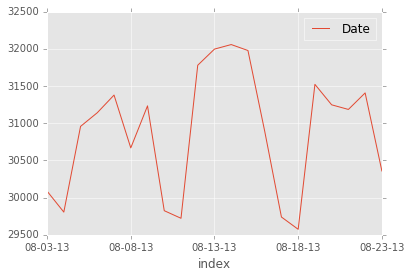

In [233]:
t_df = pd.DataFrame( df_test["Date"].value_counts() ).reset_index().sort_values("index")
t_df.set_index("index").plot()

In [39]:


df_daily["Month"]   = df_daily.apply( lambda x: str(int(x["Date"][:2])), axis=1 )
df_daily["Quarter"] = df_daily.apply( lambda x: get_quarter( int(x["Date"][:2]) ), axis=1 )


In [40]:
df_daily.head()

,Station,DeviceID,Date,DailyExit,DailyEntry,DailyTraffic,DailyMean,DailyStd,Year,Quarter,Month
1,1 AVE,H007-R248-00-00-00,05-26-13,73.0,0.0,73.0,36830.357143,190950.444686,13,2,5
2,1 AVE,H007-R248-00-00-00,05-27-13,26.0,0.0,26.0,36830.357143,190950.444686,13,2,5
3,1 AVE,H007-R248-00-00-00,05-28-13,3126.0,3423.0,6549.0,36830.357143,190950.444686,13,2,5
4,1 AVE,H007-R248-00-00-00,05-29-13,4362.0,3954.0,8316.0,36830.357143,190950.444686,13,2,5
5,1 AVE,H007-R248-00-00-00,05-30-13,4594.0,3744.0,8338.0,36830.357143,190950.444686,13,2,5


In [41]:
year    = "13"
quarter = "2"

df_q = df_daily[ (df_daily["Year"] == year) & (df_daily["Quarter"] == quarter) ]

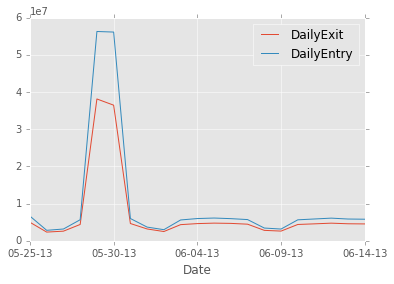

In [42]:
# Plot the daily total number of entries & exits across the system for Q3 2013.
df_test = df_q.groupby("Date").agg({"DailyEntry": "sum", "DailyExit": sum})
plt.figure(); df_test.plot();

In [69]:
# Plot the mean and standard deviation of the daily total number of entries & exits 
# for each month in Q3 2013 for station 34 ST-PENN STA.
df_test = df_q[df_q["Station"] == "34 ST-PENN STA"]

df_month_entry = df_test.groupby("Date")["DailyEntry"].agg( {"DailyEntryMean": np.mean, "DailyEntryStd": np.std} )
df_month_entry = df_month_entry.reset_index()
df_month_exit  = df_test.groupby("Date")["DailyExit"].agg( {"DailyExitMean": np.mean, "DailyExitStd": np.std} )
df_month_exit = df_month_exit.reset_index()

df_month = pd.merge(df_month_entry, df_month_exit, on='Date', how='inner').set_index("Date");
df_month.head()

means  = df_month[["DailyEntryMean", "DailyExitMean"]]
errors = df_month[["DailyEntryStd", "DailyExitStd"]]

,DailyEntryStd,DailyExitStd
Date,,
05-25-13,474.785004,806.630461
05-26-13,621.598496,681.302500
05-27-13,720.501781,667.876615
05-28-13,1255.032151,1209.545886
05-29-13,1194.658291,1139.199572


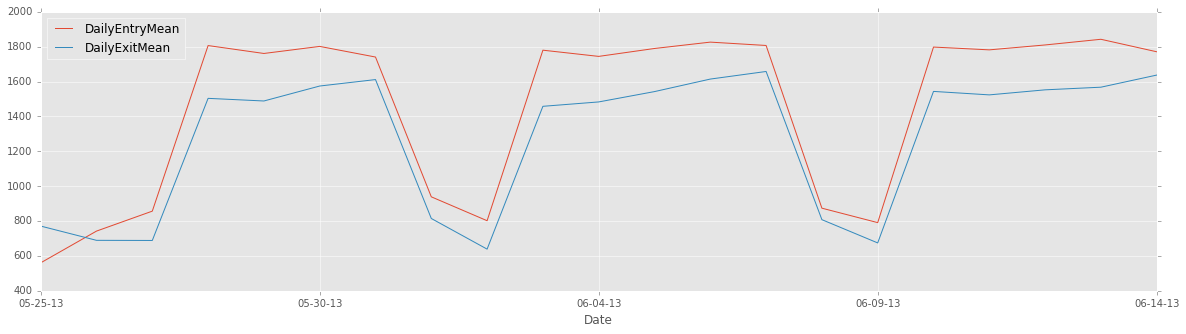

In [82]:
means.plot.line(figsize=(20,5))

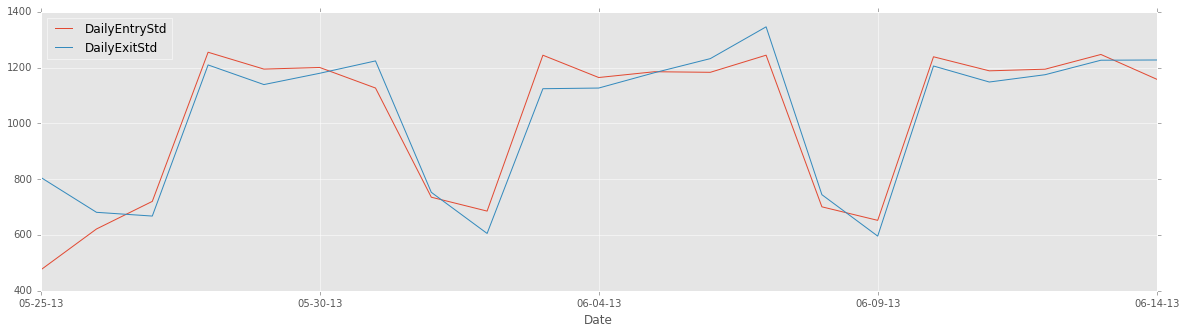

In [83]:
errors.plot.line(figsize=(20,5))

In [132]:
# Plot 25/50/75 percentile of the daily total number of entries & exits 
# for each month in Q3 2013 for station 34 ST-PENN STA.
df_test = df_q[df_q["Station"] == "34 ST-PENN STA"]
df_test_entry = df_test[["Date","DeviceID","DailyEntry"]]
df_test_exit  = df_test[["Date","DeviceID","DailyExit"]]

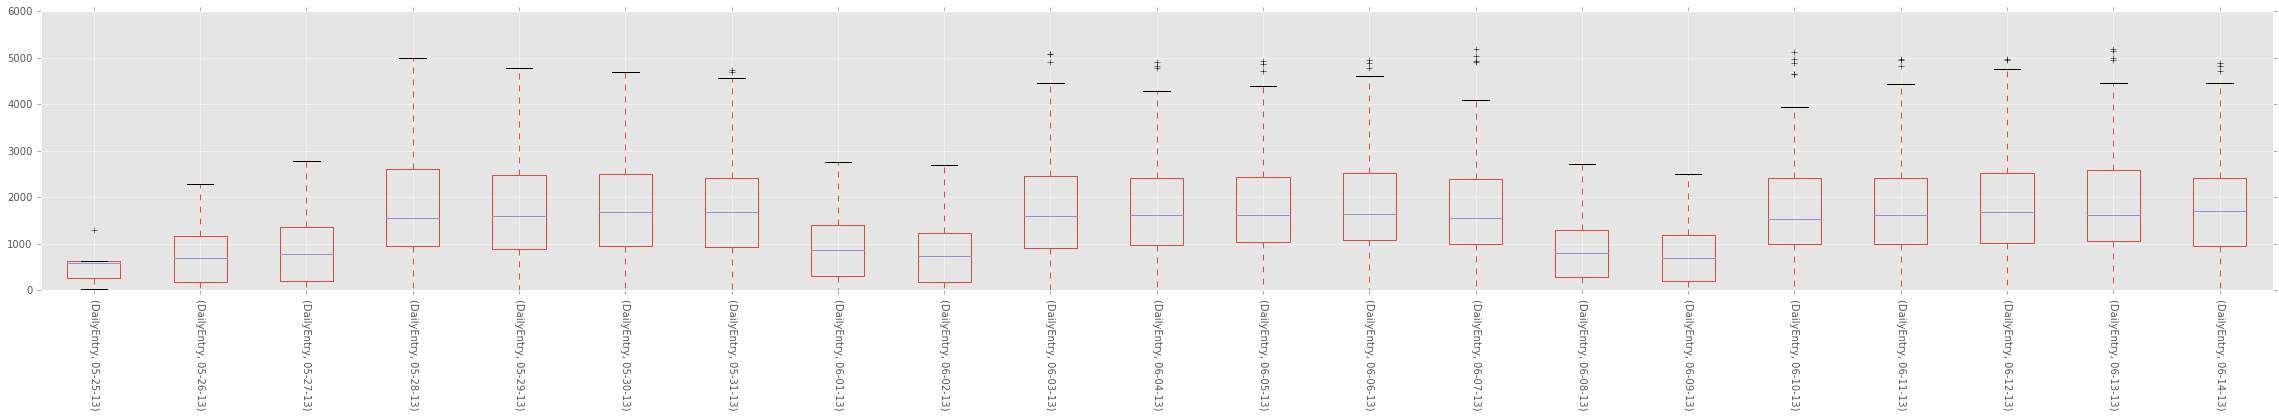

In [130]:
pivot = pd.pivot_table(df_test_entry, index=["DeviceID"], columns=["Date"], values=["DailyEntry"])
pivot.plot.box(figsize=(40,5), rot=270)

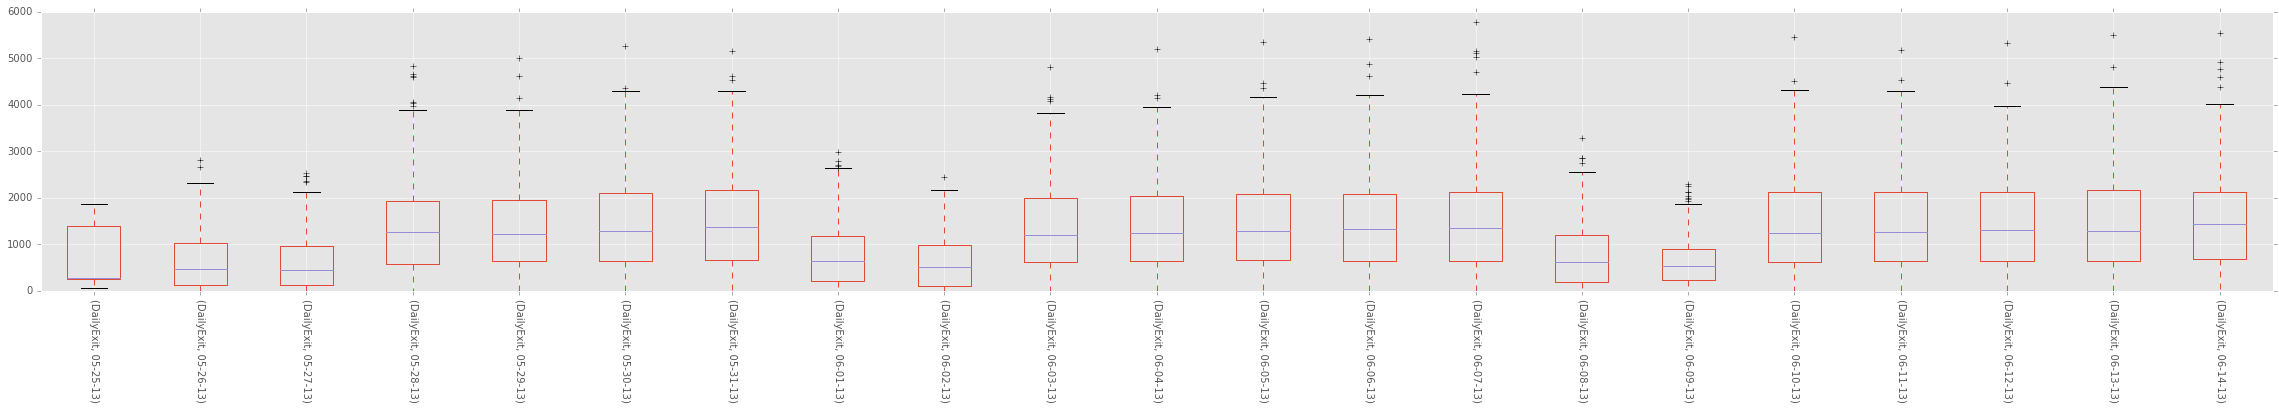

In [133]:
pivot = pd.pivot_table(df_test_exit, index=["DeviceID"], columns=["Date"], values=["DailyExit"])
pivot.plot.box(figsize=(40,5), rot=270)

In [135]:
# Plot the daily number of closed stations and number of stations 
# that were not operating at full capacity in Q3 2013.

df_test = df_q.groupby(["Station","Date"]).agg( {"DailyTraffic": 'sum'} )
df_test = df_test.reset_index()
#df_test.head()

df_stats = df_test.groupby("Station")["DailyTraffic"].agg( {
        "DailyMin" : "sum",
        "DailyMax" : "max",
        "DailyMean": "mean"
    } )
df_stats = df_stats.reset_index()

df_test = pd.merge(df_test, df_stats, on=["Station"], how='inner');
df_test.head()

,Station,Date,DailyTraffic,DailyMin,DailyMean,DailyMax
0,1 AVE,05-25-13,120.0,844626.0,40220.285714,55269.0
1,1 AVE,05-26-13,269.0,844626.0,40220.285714,55269.0
2,1 AVE,05-27-13,87.0,844626.0,40220.285714,55269.0
3,1 AVE,05-28-13,40864.0,844626.0,40220.285714,55269.0
4,1 AVE,05-29-13,47474.0,844626.0,40220.285714,55269.0


In [136]:
not_full = df_test[df_test["DailyTraffic"] < df_test["DailyMean"]]
closed   = df_test[df_test["DailyTraffic"] == 0]

In [137]:
not_full.head()

,Station,Date,DailyTraffic,DailyMin,DailyMean,DailyMax
0,1 AVE,05-25-13,120.0,844626.0,40220.285714,55269.0
1,1 AVE,05-26-13,269.0,844626.0,40220.285714,55269.0
2,1 AVE,05-27-13,87.0,844626.0,40220.285714,55269.0
8,1 AVE,06-02-13,35208.0,844626.0,40220.285714,55269.0
14,1 AVE,06-08-13,38043.0,844626.0,40220.285714,55269.0


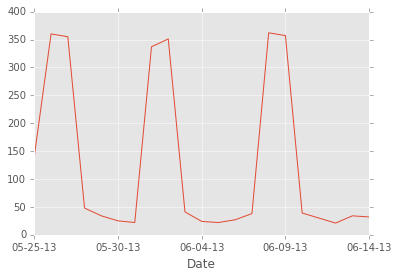

In [143]:
not_full.groupby("Date")["Station"].count().plot()

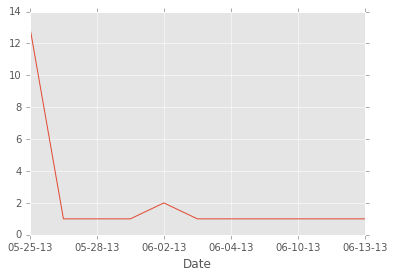

In [144]:
closed.groupby("Date")["Station"].count().plot()